# Caracterización de la Distribución (Comuna-Empresa)

La presente caracterización se hace a través de *'df_caracterizacion_regulados'*, el cual corresponde a una tabla que ha sido pre-procesada en '*Preprocesamiento_Datos_Dx.ipynb*' (normalizando registros y demás). Está hecho a partir de la información proporcionada por la Comisión Nacional de Energía a través del Anexo del cálculo del Precio Nudo Promedio (PNP). Los datos de consumo se encuentran actualizados a diciembre del 2024.

Fuentes principales de los datos:
 
- *df_caracterizacion_regulados*: [Página web CNE: Anexos PNP 2025](https://comisionenergia-my.sharepoint.com/personal/onedrive-subdeptargedis_cne_cl/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fonedrive%2Dsubdeptargedis%5Fcne%5Fcl%2FDocuments%2FPublicaciones%20WEB%2FPNP%2F2025%2D07%2FITD%2F4%2E%2DModelo%2F2%2E%2DETR%2FModelo%20nuevo%20%28python%29%2FSalidas%2FDemanda&ga=1) (Se utilizan las '*BD compilado*' y '*BD final normalizada*' del modelo ETR)
- *df_par_comuna_empresadx*: [Norma Técnica de Calidad de Servicio para Sistemas de Distribución](https://www.cne.cl/wp-content/uploads/2024/05/NTCSDx2024-1.pdf) (Anexo: Clasificación de redes)
- *df_caracterizacion_libres*: [Página web del Coordinador](https://www.coordinador.cl/mercados/documentos/transferencias-economicas-de-empresas-distribuidoras/catastro-clientes-usuarios-en-distribucion/catastro-2025/) (Base de datos "Catastro NT 1-17 Junio 2025")

In [1]:
import pandas as pd 
import numpy as np
import unidecode as ud
from sklearn.linear_model import LinearRegression
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

## Combinación de los *df* de interés

Esta base de datos cuenta con la información agregada de todos los clientes **regulados** en distribución, por lo que no cuenta con los clientes libres conectados en distribución, los cuales a pesar de ser minoría, son lo que más suman energía por unidad de cliente.

Por lo tanto, para este análisis se considerarán; solo los datos de la tabla '*df_caracterizacion_regulados*' para la información sobre los clientes regulados (residenciales y no residenciales a diciembre del 2024); y solo los datos de la tabla *'df_caracterizacion_libres'* para la información de los clientes libres conectados a distribución (a Julio del 2025). Si bien hay una diferencia temporal entre ambas bases, esto no será un problema en el futuro pues se aplicará un factor de proyección para equiparar la temporalidad de los datos (esto se hace en 'CB_implementacion_SMI_Chile.ipynb')

In [2]:
# Se carga la información a diciembre de 2024 sobre facturación de clientes regulados (CNE)
df_caracterizacion_regulados = pd.read_excel("Datos_Dx_procesados/BD final normalizada (procesados).xlsx")
df_caracterizacion_regulados

,Distribuidor,Comuna,Tipo_clientes,Tipo_de_facturacion,Cantidad_de_clientes,Energia_total_kwh,Densidad,Mapeo_Densidad
0,cec,chimbarongo,No Residencial AT,Mensual,9,50207.19,EXTREMADAMENTE BAJA,1
1,cec,chimbarongo,No Residencial BT,Mensual,1,4668.92,EXTREMADAMENTE BAJA,1
2,cec,chimbarongo,Residencial,Mensual,253,47719.28,EXTREMADAMENTE BAJA,1
3,cec,curico,No Residencial AT,Mensual,252,1891498.77,MUY BAJA,2
4,cec,curico,No Residencial BT,Mensual,104,197135.92,MUY BAJA,2
...,...,...,...,...,...,...,...,...
1429,chilquinta,la ligua,No Residencial BT,Bimensual,14,17373.00,EXTREMADAMENTE BAJA,1
1430,chilquinta,la ligua,No Residencial AT,Bimensual,17,92726.00,EXTREMADAMENTE BAJA,1
1431,coelcha,quilleco,Residencial,Bimensual,448,11085.00,EXTREMADAMENTE BAJA,1
1432,coelcha,quilleco,No Residencial BT,Bimensual,14,17373.00,EXTREMADAMENTE BAJA,1


El *'df_caracterizacion_libres'* es un dataframe con datos procesados en *'Caracterizacion_LibreDx_Jun2025_comuna-empresa (CEN).ipynb'*, los cuales fueron previamente adaptados en '*Preprocesamiento_Datos_Dx.ipynb*' (limpieza y normalización), está hecho a partir de la información proporcionada por El Coordinador a través de su base de datos pública. Los datos del consumo facturado corresponden al promedio mensual entre Junio 2024 y Junio 2025 según lo exigido en el Artículo 1-17 de la NTCSD 2024.

In [3]:
# Se cargan los datos de los clientes libres en distribución
df_caracterizacion_libres = pd.read_excel("./Datos_Dx_procesados/Caracterizacion_clientes_libres.xlsx")

df_caracterizacion_libres = df_caracterizacion_libres.rename(columns={"Cantidad_de_clientes_libreDx": "Cantidad_de_clientes_Libre_Dx"})
df_caracterizacion_libres = df_caracterizacion_libres.rename(columns={"Energia_promedio_mensual_libreDx_kWh": "Energia_promedio_mensual_Libre_Dx_kWh"})
df_caracterizacion_libres

,Distribuidor,Comuna,Cantidad_de_clientes_Libre_Dx,Energia_promedio_mensual_Libre_Dx_kWh,Cantidad_de_alimentadores
0,cec,curico,10,4203514.19,4
1,cec,romeral,6,2646471.19,2
2,cec,teno,16,8199661.19,3
3,cge,alhue,1,662063.19,2
4,cge,antofagasta,1,700931.19,25
...,...,...,...,...,...
89,luz linares,constitucion,1,990342.19,8
90,luz linares,linares,5,2789460.19,10
91,luz linares,yerbas buenas,1,624831.19,10
92,luz parral,longavi,2,1292741.19,6


### Unificación de los Clientes Regulados + Clientes Libres

In [4]:
# Se renombran columnas para que coincidan con los nombres de las otras tablas
df_caracterizacion_regulados = df_caracterizacion_regulados.rename(columns={"Energia_total_kwh": "Energia_promedio_mensual_2024_kWh"})

# Pivotar la tabla para tener 1 fila por comuna y tipo en columnas
df_caracterizacion_regulados = (df_caracterizacion_regulados.pivot_table(
                                        index=["Distribuidor", "Comuna", "Tipo_de_facturacion",
                                               "Densidad", "Mapeo_Densidad"],        							# lo que mantiene único por fila
                                        columns="Tipo_clientes",                                        		# lo que se transforma en columnas
                                        values=["Cantidad_de_clientes", "Energia_promedio_mensual_2024_kWh"],  	# qué valores redistribuir
                                        aggfunc="sum",                                                  		# cómo combinar si hay duplicados
                                        fill_value=0))

# Aplanar columnas MultiIndex (quedarán como 'Cantidad_de_clientes_Residencial', etc.)
df_caracterizacion_regulados.columns = [f"{col[0]}_{col[1]}" for col in df_caracterizacion_regulados.columns]
df_caracterizacion_regulados = df_caracterizacion_regulados.rename(columns={"Cantidad_de_clientes_No Residencial BT": "Cantidad_de_clientes_No_Residencial_BT",
                                                                            "Cantidad_de_clientes_No Residencial AT": "Cantidad_de_clientes_No_Residencial_AT",
                                                                            "Energia_promedio_mensual_2024_kWh_Residencial": "Energia_promedio_mensual_Residencial_kWh",
                                                                            "Energia_promedio_mensual_2024_kWh_No Residencial BT": "Energia_promedio_mensual_No_Residencial_BT_kWh",
                                                                            "Energia_promedio_mensual_2024_kWh_No Residencial AT": "Energia_promedio_mensual_No_Residencial_AT_kWh"})

# Resetear índice para volver a tener distribuidor y Comuna como columnas
df_caracterizacion_regulados = df_caracterizacion_regulados.reset_index()

# Se juntan las tablas df_caracterizacion_regulados, df_caracterizacion_libres
df_caracterizacion_distribucion = df_caracterizacion_regulados.merge(df_caracterizacion_libres, on=["Distribuidor", "Comuna"], how="left").fillna(0)
df_caracterizacion_distribucion

,Distribuidor,Comuna,Tipo_de_facturacion,Densidad,Mapeo_Densidad,Cantidad_de_clientes_No_Residencial_AT,Cantidad_de_clientes_No_Residencial_BT,Cantidad_de_clientes_Residencial,Energia_promedio_mensual_No_Residencial_AT_kWh,Energia_promedio_mensual_No_Residencial_BT_kWh,Energia_promedio_mensual_Residencial_kWh,Cantidad_de_clientes_Libre_Dx,Energia_promedio_mensual_Libre_Dx_kWh,Cantidad_de_alimentadores
0,cec,chimbarongo,Mensual,EXTREMADAMENTE BAJA,1,9,1,253,50207.19,4668.92,47719.28,0.0,0.00,0.0
1,cec,curico,Mensual,MUY BAJA,2,252,104,7870,1891498.77,197135.92,1749495.86,10.0,4203514.19,4.0
2,cec,molina,Mensual,EXTREMADAMENTE BAJA,1,13,2,310,114110.44,3855.17,55018.36,0.0,0.00,0.0
3,cec,romeral,Mensual,EXTREMADAMENTE BAJA,1,10,6,505,124086.27,4143.42,102692.53,6.0,2646471.19,2.0
4,cec,teno,Mensual,MUY BAJA,2,190,57,5024,945709.26,72491.42,928644.61,16.0,8199661.19,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,socoepa,la union,Mensual,EXTREMADAMENTE BAJA,1,2,2,37,548.69,6423.00,9240.20,0.0,0.00,0.0
480,socoepa,los lagos,Mensual,EXTREMADAMENTE BAJA,1,89,84,3482,495599.01,243177.58,581696.11,0.0,0.00,0.0
481,socoepa,mafil,Mensual,EXTREMADAMENTE BAJA,1,13,10,701,52571.44,37231.83,101656.61,0.0,0.00,0.0
482,socoepa,paillaco,Mensual,EXTREMADAMENTE BAJA,1,107,57,3175,683936.93,129675.25,552409.53,0.0,0.00,0.0


### Calidad y completitud de la información 

El *'df_par_comuna_empresadx'* está hecho a partir de la información proporcionada por Comisión Nacional de Energía a través de la NTCSD 2024. Realiza una clasificación sobre la densidad de clientes en el par Comuna-Empresa.

Las clasifica en 5 grupos posibles:

 - "EXTREMADAMENTE BAJA" 
 - "MUY BAJA"
 - "BAJA"
 - "MEDIA"
 - "ALTA"

In [5]:
# Se carga la tabla del par Comuna-Empresa
df_par_comuna_empresadx = pd.read_excel("./Datos_Dx_procesados/Par-Comuna-EmpresaDx (procesados).xlsx")

In [6]:
# Elementos únicos en las columnas ascociadas a Distribuidoras y Comunas 
# df_par_comuna_empresadx
empresas_unicas_df_par = set(df_par_comuna_empresadx["Distribuidor"].unique())
comunas_unicas_df_par = set(df_par_comuna_empresadx["Comuna"].unique())

# df_caracterizacion_distribucion
empresas_unicas_df_caracterizacion = set(df_caracterizacion_distribucion["Distribuidor"].unique())
comunas_unicas_df_caracterizacion = set(df_caracterizacion_distribucion["Comuna"].unique())

# Comunas y Distribuidoras en los que difieren en ambos dataframes
comunas_distintas = comunas_unicas_df_par.symmetric_difference(comunas_unicas_df_caracterizacion)
empresas_distintas = empresas_unicas_df_par.symmetric_difference(empresas_unicas_df_caracterizacion)

print(" Cantidad de Comunas evaluadas en df_clientes: ", len(comunas_unicas_df_caracterizacion), 
      "\n Cantidad de Comunas en df_par (información CNE): ", len(comunas_unicas_df_par),
      "\n -> Comunas distintas: ", len(comunas_distintas))

print("\n Cantidad de Distribuidoras evaluadas en df_clientes: ", len(empresas_unicas_df_caracterizacion), 
      "\n Cantidad de Distribuidoras en df_par (información CNE): ", len(empresas_unicas_df_par),
      "\n -> Empresas distintas: ", len(empresas_distintas))

cols = ["Comuna", "Distribuidor"]

# Se crean los pares únicos (Comuna, Empresa) en ambos dataframes para saber en los que difieren
pares_unicos_df_caracterizacion = set(map(tuple, df_caracterizacion_distribucion[cols].drop_duplicates()
                                          											  .reset_index(drop=True)
                                                                                      .to_numpy()))
pares_unicos_df_par = set(map(tuple, df_par_comuna_empresadx[cols].drop_duplicates()
                              									  .reset_index(drop=True)
                                                                  .to_numpy()))

solo_en_caracterizacion_set = pares_unicos_df_caracterizacion - pares_unicos_df_par
solo_en_par_set             = pares_unicos_df_par - pares_unicos_df_caracterizacion

# Se muestran los pares actualizados en los que difieren en ambos dataframes
print("\n----------------------------------------------------------------",
	  "\n Pares únicos (Comuna - Empresa) solo en df_clientes_regulados:")
for comuna, empresa in sorted(solo_en_caracterizacion_set):
    print(f" - Comuna - empresa: {comuna} - {empresa}")

print("\n Pares únicos (Comuna - Empresa) solo en df_par_comuna_empresadx:")
for comuna, empresa in sorted(solo_en_par_set):
    print(f" - Comuna - empresa: {comuna} - {empresa}")

 Cantidad de Comunas evaluadas en df_clientes:  330 
 Cantidad de Comunas en df_par (información CNE):  330 
 -> Comunas distintas:  0

 Cantidad de Distribuidoras evaluadas en df_clientes:  28 
 Cantidad de Distribuidoras en df_par (información CNE):  28 
 -> Empresas distintas:  0

---------------------------------------------------------------- 
 Pares únicos (Comuna - Empresa) solo en df_clientes_regulados:

 Pares únicos (Comuna - Empresa) solo en df_par_comuna_empresadx:


In [7]:
# Se suman las cantidades totales de clientes y energía
df_caracterizacion_distribucion["Cantidad_de_clientes_Libre_Dx"] = (df_caracterizacion_distribucion["Cantidad_de_clientes_Libre_Dx"]).astype(int)
df_caracterizacion_distribucion["Cantidad_de_alimentadores"] = (df_caracterizacion_distribucion["Cantidad_de_alimentadores"]).astype(int)

df_caracterizacion_distribucion["Cantidad_de_clientes_Todos"] = (df_caracterizacion_distribucion["Cantidad_de_clientes_Residencial"] +
                                                             df_caracterizacion_distribucion["Cantidad_de_clientes_No_Residencial_BT"] +
                                                             df_caracterizacion_distribucion["Cantidad_de_clientes_No_Residencial_AT"] +
                                                             df_caracterizacion_distribucion["Cantidad_de_clientes_Libre_Dx"])
df_caracterizacion_distribucion["Energia_promedio_mensual_Todos_kWh"] = ((df_caracterizacion_distribucion["Energia_promedio_mensual_Residencial_kWh"] +
                                                                           df_caracterizacion_distribucion["Energia_promedio_mensual_No_Residencial_BT_kWh"] +
                                                                           df_caracterizacion_distribucion["Energia_promedio_mensual_No_Residencial_AT_kWh"] +
                                                                           df_caracterizacion_distribucion["Energia_promedio_mensual_Libre_Dx_kWh"])).round(2)
# Se reordenan las columnas para la visualización
cols = [
    "Distribuidor",
    "Comuna",
    "Cantidad_de_clientes_Todos",
    "Cantidad_de_clientes_Residencial",
    "Cantidad_de_clientes_No_Residencial_BT",
    "Cantidad_de_clientes_No_Residencial_AT",
    "Cantidad_de_clientes_Libre_Dx",
    "Energia_promedio_mensual_Todos_kWh",
    "Energia_promedio_mensual_Residencial_kWh",
    "Energia_promedio_mensual_No_Residencial_BT_kWh",
    "Energia_promedio_mensual_No_Residencial_AT_kWh",
    "Energia_promedio_mensual_Libre_Dx_kWh",
    "Tipo_de_facturacion",
    "Cantidad_de_alimentadores",
    "Densidad",
    "Mapeo_Densidad"
]

df_caracterizacion_distribucion = df_caracterizacion_distribucion[cols]
df_caracterizacion_distribucion

,Distribuidor,Comuna,Cantidad_de_clientes_Todos,Cantidad_de_clientes_Residencial,Cantidad_de_clientes_No_Residencial_BT,Cantidad_de_clientes_No_Residencial_AT,Cantidad_de_clientes_Libre_Dx,Energia_promedio_mensual_Todos_kWh,Energia_promedio_mensual_Residencial_kWh,Energia_promedio_mensual_No_Residencial_BT_kWh,Energia_promedio_mensual_No_Residencial_AT_kWh,Energia_promedio_mensual_Libre_Dx_kWh,Tipo_de_facturacion,Cantidad_de_alimentadores,Densidad,Mapeo_Densidad
0,cec,chimbarongo,263,253,1,9,0,102595.39,47719.28,4668.92,50207.19,0.00,Mensual,0,EXTREMADAMENTE BAJA,1
1,cec,curico,8236,7870,104,252,10,8041644.74,1749495.86,197135.92,1891498.77,4203514.19,Mensual,4,MUY BAJA,2
2,cec,molina,325,310,2,13,0,172983.97,55018.36,3855.17,114110.44,0.00,Mensual,0,EXTREMADAMENTE BAJA,1
3,cec,romeral,527,505,6,10,6,2877393.41,102692.53,4143.42,124086.27,2646471.19,Mensual,2,EXTREMADAMENTE BAJA,1
4,cec,teno,5287,5024,57,190,16,10146506.48,928644.61,72491.42,945709.26,8199661.19,Mensual,3,MUY BAJA,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,socoepa,la union,41,37,2,2,0,16211.89,9240.20,6423.00,548.69,0.00,Mensual,0,EXTREMADAMENTE BAJA,1
480,socoepa,los lagos,3655,3482,84,89,0,1320472.70,581696.11,243177.58,495599.01,0.00,Mensual,0,EXTREMADAMENTE BAJA,1
481,socoepa,mafil,724,701,10,13,0,191459.88,101656.61,37231.83,52571.44,0.00,Mensual,0,EXTREMADAMENTE BAJA,1
482,socoepa,paillaco,3339,3175,57,107,0,1366021.71,552409.53,129675.25,683936.93,0.00,Mensual,0,EXTREMADAMENTE BAJA,1


### Estimación de la Cantidad de Alimentadores por par Comuna-Empresa

In [8]:
# Correlación entre la cantidad de alimentadores y la cantidad de clientes y energía (cantidad de alimentadores != 0)
df = df_caracterizacion_distribucion.loc[df_caracterizacion_distribucion["Cantidad_de_alimentadores"] != 0].copy()

correlacion = df[["Cantidad_de_alimentadores", "Cantidad_de_clientes_Todos", "Energia_promedio_mensual_Todos_kWh"]].corr()
pprint(correlacion)

                                    Cantidad_de_alimentadores  \
Cantidad_de_alimentadores                            1.000000   
Cantidad_de_clientes_Todos                           0.871651   
Energia_promedio_mensual_Todos_kWh                   0.617499   

                                    Cantidad_de_clientes_Todos  \
Cantidad_de_alimentadores                             0.871651   
Cantidad_de_clientes_Todos                            1.000000   
Energia_promedio_mensual_Todos_kWh                    0.605561   

                                    Energia_promedio_mensual_Todos_kWh  
Cantidad_de_alimentadores                                     0.617499  
Cantidad_de_clientes_Todos                                    0.605561  
Energia_promedio_mensual_Todos_kWh                            1.000000  


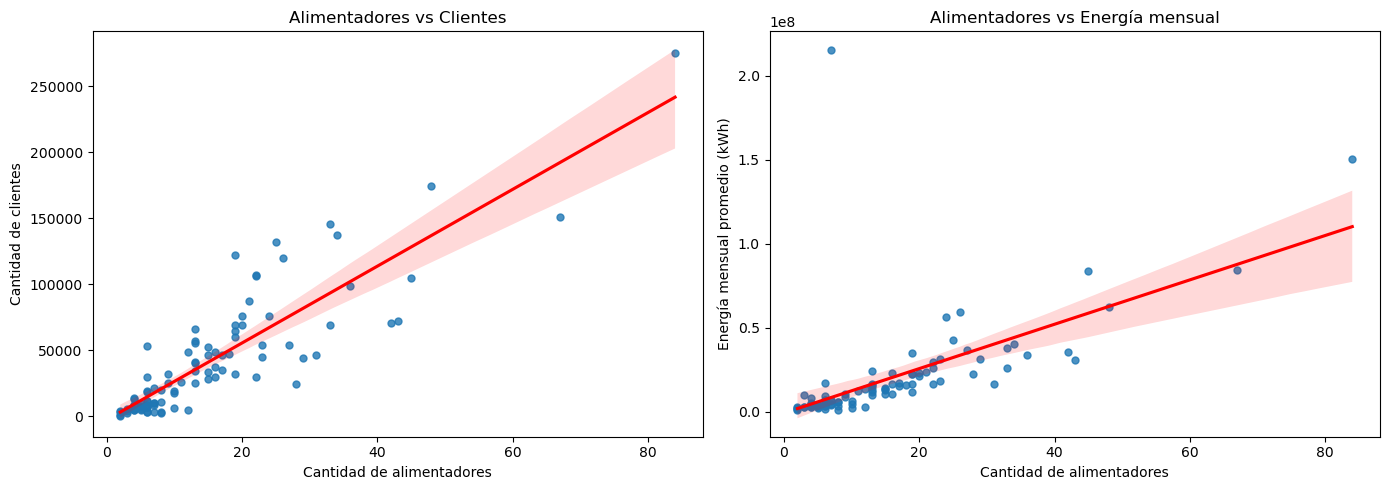

In [9]:
# Columnas de interés
x = "Cantidad_de_alimentadores"
y1 = "Cantidad_de_clientes_Todos"
y2 = "Energia_promedio_mensual_Todos_kWh"

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(
    data=df,
    x=x, y=y1,
    ax=axes[0],
    scatter_kws={"s": 25},
    line_kws={"color": "red"}
)
axes[0].set_title("Alimentadores vs Clientes")
axes[0].set_xlabel("Cantidad de alimentadores")
axes[0].set_ylabel("Cantidad de clientes")

sns.regplot(
    data=df,
    x=x, y=y2,
    ax=axes[1],
    scatter_kws={"s": 25},
    line_kws={"color": "red"}
)
axes[1].set_title("Alimentadores vs Energía mensual")
axes[1].set_xlabel("Cantidad de alimentadores")
axes[1].set_ylabel("Energía mensual promedio (kWh)")

plt.tight_layout()
plt.show()

In [10]:
# Entrenamiento con filas válidas (alimentadores > 0)
df_caracterizacion_distribucion_estimacion = df_caracterizacion_distribucion.copy()

df_train = df_caracterizacion_distribucion_estimacion[(df_caracterizacion_distribucion_estimacion["Cantidad_de_alimentadores"] > 0)].copy()

X = df_train[["Cantidad_de_clientes_Todos", "Energia_promedio_mensual_Todos_kWh"]].values
y = df_train["Cantidad_de_alimentadores"].values

# Se entrena el modelo
modelo_lineal = LinearRegression()
modelo_lineal.fit(X, y)

print("Coef clientes:", modelo_lineal.coef_[0])
print("Coef energia:", modelo_lineal.coef_[1])
#print("Coef densidad:", modelo_lineal.coef_[2])
print("Constante C:", modelo_lineal.intercept_)
print("R^2 (entrenamiento):", modelo_lineal.score(X, y))

# Se crea una nueva columna sobre la cantidad de alimentadores estimada con valores nulos
df_caracterizacion_distribucion_estimacion["Cantidad_de_alimentadores_estimado"] = np.nan

# Se establecen las filas a estimar (donde Cantidad_de_alimentadores == 0)
faltantes = df_caracterizacion_distribucion_estimacion["Cantidad_de_alimentadores"] == 0
X_faltantes = df_caracterizacion_distribucion_estimacion.loc[faltantes, ["Cantidad_de_clientes_Todos", 
                                                                         "Energia_promedio_mensual_Todos_kWh"]].values

# Predicción y limpieza
y_prediccion = modelo_lineal.predict(X_faltantes)
y_prediccion = np.maximum(y_prediccion, 1)               # si se estima 0 , se asigna 1
y_prediccion = np.round(y_prediccion).astype(int)        # Deben ser enteros

# Se guarda en la nueva columna
df_caracterizacion_distribucion_estimacion.loc[faltantes, "Cantidad_de_alimentadores_estimado"] = y_prediccion
df_caracterizacion_distribucion_estimacion["Cantidad_de_alimentadores_estimado"] = (df_caracterizacion_distribucion_estimacion["Cantidad_de_alimentadores_estimado"]
                                                                                    .fillna(0).astype(int))

Coef clientes: 0.0002355535021963078
Coef energia: 6.625965753576831e-08
Constante C: 4.221165537712862
R^2 (entrenamiento): 0.7724692375804446


In [11]:
# Se actualiza la columna 'Cantidad_de_alimentadores' en el df_caracterizacion_distribucion
df_caracterizacion_distribucion["Cantidad_de_alimentadores"] = (df_caracterizacion_distribucion_estimacion["Cantidad_de_alimentadores"]
                                                                    .where(df_caracterizacion_distribucion_estimacion["Cantidad_de_alimentadores"] > 0, 
                                                                            df_caracterizacion_distribucion_estimacion["Cantidad_de_alimentadores_estimado"])).astype(int)

df_caracterizacion_distribucion = df_caracterizacion_distribucion.drop(columns=["Mapeo_Densidad"])
df_caracterizacion_distribucion

,Distribuidor,Comuna,Cantidad_de_clientes_Todos,Cantidad_de_clientes_Residencial,Cantidad_de_clientes_No_Residencial_BT,Cantidad_de_clientes_No_Residencial_AT,Cantidad_de_clientes_Libre_Dx,Energia_promedio_mensual_Todos_kWh,Energia_promedio_mensual_Residencial_kWh,Energia_promedio_mensual_No_Residencial_BT_kWh,Energia_promedio_mensual_No_Residencial_AT_kWh,Energia_promedio_mensual_Libre_Dx_kWh,Tipo_de_facturacion,Cantidad_de_alimentadores,Densidad
0,cec,chimbarongo,263,253,1,9,0,102595.39,47719.28,4668.92,50207.19,0.00,Mensual,4,EXTREMADAMENTE BAJA
1,cec,curico,8236,7870,104,252,10,8041644.74,1749495.86,197135.92,1891498.77,4203514.19,Mensual,4,MUY BAJA
2,cec,molina,325,310,2,13,0,172983.97,55018.36,3855.17,114110.44,0.00,Mensual,4,EXTREMADAMENTE BAJA
3,cec,romeral,527,505,6,10,6,2877393.41,102692.53,4143.42,124086.27,2646471.19,Mensual,2,EXTREMADAMENTE BAJA
4,cec,teno,5287,5024,57,190,16,10146506.48,928644.61,72491.42,945709.26,8199661.19,Mensual,3,MUY BAJA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,socoepa,la union,41,37,2,2,0,16211.89,9240.20,6423.00,548.69,0.00,Mensual,4,EXTREMADAMENTE BAJA
480,socoepa,los lagos,3655,3482,84,89,0,1320472.70,581696.11,243177.58,495599.01,0.00,Mensual,5,EXTREMADAMENTE BAJA
481,socoepa,mafil,724,701,10,13,0,191459.88,101656.61,37231.83,52571.44,0.00,Mensual,4,EXTREMADAMENTE BAJA
482,socoepa,paillaco,3339,3175,57,107,0,1366021.71,552409.53,129675.25,683936.93,0.00,Mensual,5,EXTREMADAMENTE BAJA


In [12]:
# Información a Dic 2024
# -> Cantidad de clientes
# -> Cantidad de energía
cantidad_clientes_en_distribucion = df_caracterizacion_distribucion['Cantidad_de_clientes_Todos'].sum()
cantidad_energia_en_distribucion = df_caracterizacion_distribucion['Energia_promedio_mensual_Todos_kWh'].sum()

print("(A fecha de diciembre 2024)",
      "\nClientes en distribución:",
      "\n -> Cantidad de clientes: {:,}".format(cantidad_clientes_en_distribucion),
      "\n -> Energía facturada mensual: {:,} TWh".format((cantidad_energia_en_distribucion / 1_000_000_000).round(2)))

(A fecha de diciembre 2024) 
Clientes en distribución: 
 -> Cantidad de clientes: 7,625,691 
 -> Energía facturada mensual: 2.83 TWh


## Incorporación de las pérdidas en Dx

In [17]:
df_hurto = pd.read_excel('./Datos_Dx_procesados/Pérdidas No Técnicas (Hurto) (procesados).xlsx')
df_comercial = pd.read_excel('./Datos_Dx_procesados/Pérdidas No Técnicas (Comercial) (procesados).xlsx')
df_perdidasdx = pd.read_excel("./Datos_Dx_procesados/Perdidas (procesados).xlsx")

In [19]:
# Se complementa la información de df_hurto con los datos de df_perdidasdx
# Se renombra la columna de pérdidas de energía para que coincida con df_hurto
df_perdidasdx = df_perdidasdx.rename(columns={"Pérdidas de energía [1/u]": "Hurto de energía [pu]"})

# Columnas en común
cols = ["Distribuidor", "Hurto de energía [pu]"]

# Registros de df_perdidasdx que no están en df_hurto
faltantes = df_perdidasdx.loc[~df_perdidasdx["Distribuidor"].isin(df_hurto["Distribuidor"]), cols]

# Se agregan al final de df_hurto
df_hurto = pd.concat([df_hurto[cols], faltantes], ignore_index=True)
df_hurto

,Distribuidor,Hurto de energía [pu]
0,enel distribucion,0.0128
1,cge,0.0500
2,chilquinta,0.0769
3,saesa,0.0164
4,frontel,0.0510
5,edelaysen,0.0432
6,eepa,0.0115
7,cooprel,0.0250
8,cec,0.0388
9,copelec,0.0795


In [20]:
# Se complementa la información de df_comercial con los datos de df_perdidasdx
# Se renombra la columna de pérdidas de energía para que coincida con df_comercial
df_perdidasdx = df_perdidasdx.rename(columns={"Hurto de energía [pu]": "PC [pu]"})

# Columnas en común
cols = ["Distribuidor", "PC [pu]"]

# Registros de df_perdidasdx que no están en df_comercial
faltantes = df_perdidasdx.loc[~df_perdidasdx["Distribuidor"].isin(df_comercial["Distribuidor"]), cols]

# Se agregan al final de df_comercial
df_comercial = pd.concat([df_comercial[cols], faltantes], ignore_index=True)
df_comercial

,Distribuidor,PC [pu]
0,enel distribucion,0.0108
1,cge,0.0133
2,chilquinta,0.0075
3,saesa,0.0102
4,frontel,0.0217
5,edelaysen,0.0091
6,eepa,0.0407
7,cooprel,0.0700
8,cec,0.0097
9,copelec,0.0303


In [21]:
df_perdidasdx

,Distribuidor,PC [pu]
0,socoepa,0.0158
1,coelcha,0.0292
2,frontel,0.0292
3,electrica colina,0.0146
4,emelca,0.0162
5,cec,0.0292
6,saesa,0.0166
7,cge,0.0257
8,coopersol,0.0116
9,luz parral,0.0292


Considerando que son factores de pérdidas porcentuales, para una misma empresa distribuidora con distintas comunas lo que se hará será asignarle el mismo factor a cada uno de estos pares comuna-empresa.

In [16]:
# Se completan los datos de pérdidas de la empresa que falta con el promedio de las pérdidas
# 'edelmag'
perdidas_faltantes = [
	{"Distribuidor": "edelmag", "Hurto de energía [pu]": df_perdidasdx["PC [pu]"].mean().round(4)}
]

df_hurto = pd.concat([df_hurto, pd.DataFrame(perdidas_faltantes)], ignore_index=True)
df_comercial = pd.concat([df_comercial, pd.DataFrame(perdidas_faltantes).rename(columns={"Hurto de energía [pu]": "PC [pu]"})], ignore_index=True)

# Se asignan las perdidas a los pares comuna-empresa del df_caracterizacion_distribucion
df_caracterizacion_distribucion = df_caracterizacion_distribucion.merge(df_hurto, on=["Distribuidor"], how="left")
df_caracterizacion_distribucion = df_caracterizacion_distribucion.merge(df_comercial, on=["Distribuidor"], how="left")

# Se complementa la información de df_perdidas con los datos de df_hurto
# Se renombran las columnas a pérdidas de energía
df_hurto = df_hurto.rename(columns={"Hurto de energía [pu]": "Pérdidas de energía [pu]"})
df_perdidasdx = df_perdidasdx.rename(columns={"PC [pu]": "Pérdidas de energía [pu]"})

# Columnas en común
cols = ["Distribuidor", "Pérdidas de energía [pu]"]

# Registros de df_hurto que no están en df_perdidasdx
faltantes = df_hurto.loc[~df_hurto["Distribuidor"].isin(df_perdidasdx["Distribuidor"]), cols]

# Se agregan al final de df_perdidasdx
df_perdidasdx = pd.concat([df_perdidasdx[cols], faltantes], ignore_index=True)

df_caracterizacion_distribucion = df_caracterizacion_distribucion.merge(df_perdidasdx, on=["Distribuidor"], how="left")
df_caracterizacion_distribucion

,Distribuidor,Comuna,Cantidad_de_clientes_Todos,Cantidad_de_clientes_Residencial,Cantidad_de_clientes_No_Residencial_BT,Cantidad_de_clientes_No_Residencial_AT,Cantidad_de_clientes_Libre_Dx,Energia_promedio_mensual_Todos_kWh,Energia_promedio_mensual_Residencial_kWh,Energia_promedio_mensual_No_Residencial_BT_kWh,Energia_promedio_mensual_No_Residencial_AT_kWh,Energia_promedio_mensual_Libre_Dx_kWh,Tipo_de_facturacion,Cantidad_de_alimentadores,Densidad,Hurto de energía [pu],PC [pu],Pérdidas de energía [pu]
0,cec,chimbarongo,263,253,1,9,0,102595.39,47719.28,4668.92,50207.19,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0388,0.0097,0.0292
1,cec,curico,8236,7870,104,252,10,8041644.74,1749495.86,197135.92,1891498.77,4203514.19,Mensual,4,MUY BAJA,0.0388,0.0097,0.0292
2,cec,molina,325,310,2,13,0,172983.97,55018.36,3855.17,114110.44,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0388,0.0097,0.0292
3,cec,romeral,527,505,6,10,6,2877393.41,102692.53,4143.42,124086.27,2646471.19,Mensual,2,EXTREMADAMENTE BAJA,0.0388,0.0097,0.0292
4,cec,teno,5287,5024,57,190,16,10146506.48,928644.61,72491.42,945709.26,8199661.19,Mensual,3,MUY BAJA,0.0388,0.0097,0.0292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,socoepa,la union,41,37,2,2,0,16211.89,9240.20,6423.00,548.69,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158
480,socoepa,los lagos,3655,3482,84,89,0,1320472.70,581696.11,243177.58,495599.01,0.00,Mensual,5,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158
481,socoepa,mafil,724,701,10,13,0,191459.88,101656.61,37231.83,52571.44,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158
482,socoepa,paillaco,3339,3175,57,107,0,1366021.71,552409.53,129675.25,683936.93,0.00,Mensual,5,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158


## Incorporación de la cantidad de TD

Fuente de los datos: [Anexos VAD 2024-2028](https://comisionenergia-my.sharepoint.com/personal/onedrive-subdeptargedis_cne_cl/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Fonedrive%2Dsubdeptargedis%5Fcne%5Fcl%2FDocuments%2FPublicaciones%20WEB%2FVAD%2FVAD%202024%2D2028%2F02%20Informe%20T%C3%A9cnico%20Preliminar%2FATD1%2FAnexos%2FAnexo%204%2FAnexo%204%2D10%20SMMC&viewid=f5258698%2D4137%2D4785%2Da047%2D925c3d159fd9&ga=1)

In [46]:
df_um_transformadoresdx = pd.read_excel("./Datos_Dx_procesados/Cantidad_de_transformadores_por_empresadx (procesados).xlsx")
df_um_transformadoresdx

,Distribuidor,UM3F 1S para TD,UM3F 2S para TD,UM1F 1S para TD
0,enel,6023,15241,483
1,cge,10298,33915,4288
2,chilquinta,1201,5813,457
3,saesa,2688,10227,3357
4,frontel,2914,10630,5276
5,edelaysen,238,845,717
6,eepa,113,604,12
7,cooprel,563,476,697
8,cec,109,379,86
9,copelec,1040,3690,1911


In [47]:
# Se modifica los nombres de algunos datos para que coincidan al hacer el merge
df_um_transformadoresdx.loc[df_um_transformadoresdx["Distribuidor"].isin(["enel"]), "Distribuidor"] = "enel distribucion"

df_caracterizacion_distribucion_td = df_caracterizacion_distribucion.merge(df_um_transformadoresdx, on=["Distribuidor"], how="left").fillna(0)
df_caracterizacion_distribucion_td

,Distribuidor,Comuna,Cantidad_de_clientes_Todos,Cantidad_de_clientes_Residencial,Cantidad_de_clientes_No_Residencial_BT,Cantidad_de_clientes_No_Residencial_AT,Cantidad_de_clientes_Libre_Dx,Energia_promedio_mensual_Todos_kWh,Energia_promedio_mensual_Residencial_kWh,Energia_promedio_mensual_No_Residencial_BT_kWh,...,Energia_promedio_mensual_Libre_Dx_kWh,Tipo_de_facturacion,Cantidad_de_alimentadores,Densidad,Hurto de energía [pu],PC [pu],Pérdidas de energía [pu],UM3F 1S para TD,UM3F 2S para TD,UM1F 1S para TD
0,cec,chimbarongo,263,253,1,9,0,102595.39,47719.28,4668.92,...,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0388,0.0097,0.0292,109.0,379.0,86.0
1,cec,curico,8236,7870,104,252,10,8041644.74,1749495.86,197135.92,...,4203514.19,Mensual,4,MUY BAJA,0.0388,0.0097,0.0292,109.0,379.0,86.0
2,cec,molina,325,310,2,13,0,172983.97,55018.36,3855.17,...,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0388,0.0097,0.0292,109.0,379.0,86.0
3,cec,romeral,527,505,6,10,6,2877393.41,102692.53,4143.42,...,2646471.19,Mensual,2,EXTREMADAMENTE BAJA,0.0388,0.0097,0.0292,109.0,379.0,86.0
4,cec,teno,5287,5024,57,190,16,10146506.48,928644.61,72491.42,...,8199661.19,Mensual,3,MUY BAJA,0.0388,0.0097,0.0292,109.0,379.0,86.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,socoepa,la union,41,37,2,2,0,16211.89,9240.20,6423.00,...,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158,0.0,0.0,0.0
480,socoepa,los lagos,3655,3482,84,89,0,1320472.70,581696.11,243177.58,...,0.00,Mensual,5,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158,0.0,0.0,0.0
481,socoepa,mafil,724,701,10,13,0,191459.88,101656.61,37231.83,...,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158,0.0,0.0,0.0
482,socoepa,paillaco,3339,3175,57,107,0,1366021.71,552409.53,129675.25,...,0.00,Mensual,5,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158,0.0,0.0,0.0


In [49]:
## Se busca conocer la correlación entre la cantidad de UM3F 1S para TD, Cantidad de alimentadores y Cantidad de clientes para asignar pesos
# Se agrupa el df_caracterizacion_distribucion_td por comuna y distribuidor, sumando las cantidades de clientes, energía y alimentadores
df_caracterizacion_distribucion_td_agrupado = (
	df_caracterizacion_distribucion_td
	.groupby(["Distribuidor"], as_index=False)
	.agg({
		"Cantidad_de_clientes_Todos": "sum",
		"Cantidad_de_alimentadores": "sum",
        "UM3F 1S para TD": "first",
		"UM3F 2S para TD": "first",
        "UM1F 1S para TD": "first"
	})
)

# Se buscan filas con UM3F 1S para TD, UM3F 2S para TD, UM1F 1S para TD distintas de 0 para analizarlas
df = df_caracterizacion_distribucion_td_agrupado.loc[(df_caracterizacion_distribucion_td_agrupado["UM3F 1S para TD"] != 0) |
												(df_caracterizacion_distribucion_td_agrupado["UM3F 2S para TD"] != 0) |
												(df_caracterizacion_distribucion_td_agrupado["UM1F 1S para TD"] != 0)].copy()

# Correlacion entre la cantidad de UM3F 1S para TD, Cantidad de alimentadores y Cantidad de clientes
correlacion_td = df[["UM3F 2S para TD", "Cantidad_de_alimentadores", "Cantidad_de_clientes_Todos"]].corr()
pprint(correlacion_td)

                            UM3F 2S para TD  Cantidad_de_alimentadores  \
UM3F 2S para TD                    1.000000                   0.986014   
Cantidad_de_alimentadores          0.986014                   1.000000   
Cantidad_de_clientes_Todos         0.953605                   0.988502   

                            Cantidad_de_clientes_Todos  
UM3F 2S para TD                               0.953605  
Cantidad_de_alimentadores                     0.988502  
Cantidad_de_clientes_Todos                    1.000000  


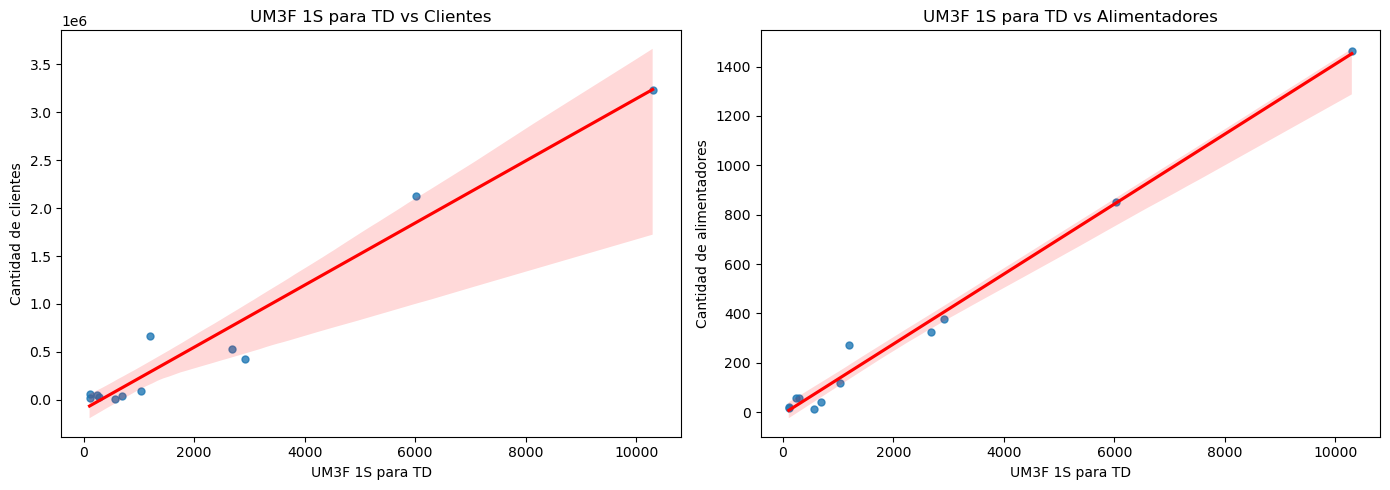

In [20]:
# Columnas de interés
x = "UM3F 1S para TD"
y1 = "Cantidad_de_clientes_Todos"
y2 = "Cantidad_de_alimentadores"

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.regplot(
    data=df,
    x=x, y=y1,
    ax=axes[0],
    scatter_kws={"s": 25},
    line_kws={"color": "red"}
)
axes[0].set_title("UM3F 1S para TD vs Clientes")
axes[0].set_xlabel("UM3F 1S para TD")
axes[0].set_ylabel("Cantidad de clientes")

sns.regplot(
    data=df,
    x=x, y=y2,
    ax=axes[1],
    scatter_kws={"s": 25},
    line_kws={"color": "red"}
)
axes[1].set_title("UM3F 1S para TD vs Alimentadores")
axes[1].set_xlabel("UM3F 1S para TD")
axes[1].set_ylabel("Cantidad de alimentadores")

plt.tight_layout()
plt.show()

Se busca hacer una distribución de la cantidad de TD por empresa entre los pares comuna-empresa, para ello, se utilizará la cantidad de clientes y la cantidad de alimentadores MT del par para poder hacer una estimación en la división. Esta estimación se hará a través de un peso combinado de ambas variables, dada la formula:

$\text{peso combinado} = \lambda * \text{Peso N° clientes} + (1-\lambda) * \text{Peso N° Alimentadores}$

In [21]:
# Se calculan los pesos relativos y el combinado entre Cantidad de clientes y Cantidad de alimentadores
# Peso según clientes dentro de cada distribuidor
total_cli_por_dist = df_caracterizacion_distribucion_td.groupby("Distribuidor")["Cantidad_de_clientes_Todos"].transform("sum")
df_caracterizacion_distribucion_td["peso_clientes"] = df_caracterizacion_distribucion_td["Cantidad_de_clientes_Todos"] / total_cli_por_dist

# Peso según alimentadores dentro de cada distribuidor
total_alim_por_dist = df_caracterizacion_distribucion_td.groupby("Distribuidor")["Cantidad_de_alimentadores"].transform("sum")
df_caracterizacion_distribucion_td["peso_alimentadores"] = df_caracterizacion_distribucion_td["Cantidad_de_alimentadores"] / total_alim_por_dist

lambda_ = 0.45 	# Confiabilidad en Cantidad de clientes

df_caracterizacion_distribucion_td["peso_combinado"] = (lambda_ * df_caracterizacion_distribucion_td["peso_clientes"]
                                                         + (1 - lambda_) * df_caracterizacion_distribucion_td["peso_alimentadores"])

# Se calcula la proporcion de unidades de medida por transformadores
df_caracterizacion_distribucion_td["Proporcion_UM3F_1S_por_par"] = (df_caracterizacion_distribucion_td["UM3F 1S para TD"]
                                                                     * df_caracterizacion_distribucion_td["peso_combinado"]).round()

df_caracterizacion_distribucion_td["Proporcion_UM3F_2S_por_par"] = (df_caracterizacion_distribucion_td["UM3F 2S para TD"]
                                                                     * df_caracterizacion_distribucion_td["peso_combinado"]).round()

df_caracterizacion_distribucion_td["Proporcion_UM1F_1S_por_par"] = (df_caracterizacion_distribucion_td["UM1F 1S para TD"]
                                                                     * df_caracterizacion_distribucion_td["peso_combinado"]).round()


# Se limpia el dataframe de columnas ya utilizadas para el cálculo
df_caracterizacion_distribucion_td = df_caracterizacion_distribucion_td.drop(columns=["UM3F 1S para TD", "UM3F 2S para TD", "UM1F 1S para TD",
                                                                                      "peso_clientes", "peso_alimentadores", "peso_combinado"])
df_caracterizacion_distribucion_td

,Distribuidor,Comuna,Cantidad_de_clientes_Todos,Cantidad_de_clientes_Residencial,Cantidad_de_clientes_No_Residencial_BT,Cantidad_de_clientes_No_Residencial_AT,Cantidad_de_clientes_Libre_Dx,Energia_promedio_mensual_Todos_kWh,Energia_promedio_mensual_Residencial_kWh,Energia_promedio_mensual_No_Residencial_BT_kWh,...,Energia_promedio_mensual_Libre_Dx_kWh,Tipo_de_facturacion,Cantidad_de_alimentadores,Densidad,Hurto de energía [pu],PC [pu],Pérdidas de energía [pu],Proporcion_UM3F_1S_por_par,Proporcion_UM3F_2S_por_par,Proporcion_UM1F_1S_por_par
0,cec,chimbarongo,263,253,1,9,0,102595.39,47719.28,4668.92,...,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0388,0.0097,0.0292,15.0,52.0,12.0
1,cec,curico,8236,7870,104,252,10,8041644.74,1749495.86,197135.92,...,4203514.19,Mensual,4,MUY BAJA,0.0388,0.0097,0.0292,42.0,145.0,33.0
2,cec,molina,325,310,2,13,0,172983.97,55018.36,3855.17,...,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0388,0.0097,0.0292,15.0,53.0,12.0
3,cec,romeral,527,505,6,10,6,2877393.41,102692.53,4143.42,...,2646471.19,Mensual,2,EXTREMADAMENTE BAJA,0.0388,0.0097,0.0292,9.0,31.0,7.0
4,cec,teno,5287,5024,57,190,16,10146506.48,928644.61,72491.42,...,8199661.19,Mensual,3,MUY BAJA,0.0388,0.0097,0.0292,28.0,98.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,socoepa,la union,41,37,2,2,0,16211.89,9240.20,6423.00,...,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158,0.0,0.0,0.0
480,socoepa,los lagos,3655,3482,84,89,0,1320472.70,581696.11,243177.58,...,0.00,Mensual,5,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158,0.0,0.0,0.0
481,socoepa,mafil,724,701,10,13,0,191459.88,101656.61,37231.83,...,0.00,Mensual,4,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158,0.0,0.0,0.0
482,socoepa,paillaco,3339,3175,57,107,0,1366021.71,552409.53,129675.25,...,0.00,Mensual,5,EXTREMADAMENTE BAJA,0.0158,0.0158,0.0158,0.0,0.0,0.0


In [22]:
# Se realiza una regresión lineal para estimar las UM en TD que faltan (ie, aquellas que tienen 0 unidades asignadas)

# Entrenamiento con filas válidas (UM > 0)
df_caracterizacion_distribucion_td_estimacion = df_caracterizacion_distribucion_td.copy()

df_train_um3f_1s = df_caracterizacion_distribucion_td_estimacion[(df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_1S_por_par"] > 0)].copy()
df_train_um3f_2s = df_caracterizacion_distribucion_td_estimacion[(df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_2S_por_par"] > 0)].copy()
df_train_um1f_1s = df_caracterizacion_distribucion_td_estimacion[(df_caracterizacion_distribucion_td_estimacion["Proporcion_UM1F_1S_por_par"] > 0)].copy()

X_um3f_1s = df_train_um3f_1s[["Cantidad_de_clientes_Todos"]].values
y_um3f_1s = df_train_um3f_1s["Proporcion_UM3F_1S_por_par"].values

X_um3f_2s = df_train_um3f_2s[["Cantidad_de_clientes_Todos"]].values
y_um3f_2s = df_train_um3f_2s["Proporcion_UM3F_2S_por_par"].values

X_um1f_1s = df_train_um1f_1s[["Cantidad_de_clientes_Todos"]].values
y_um1f_1s = df_train_um1f_1s["Proporcion_UM1F_1S_por_par"].values

# Se entrena el modelo
modelo_lineal_um3f_1s = LinearRegression()
modelo_lineal_um3f_1s.fit(X_um3f_1s, y_um3f_1s)

# Se entrena el modelo
modelo_lineal_um3f_2s = LinearRegression()
modelo_lineal_um3f_2s.fit(X_um3f_2s, y_um3f_2s)

# Se entrena el modelo
modelo_lineal_um1f_1s = LinearRegression()
modelo_lineal_um1f_1s.fit(X_um1f_1s, y_um1f_1s)

print("Coef clientes:", modelo_lineal_um3f_1s.coef_[0])
print("Constante C:", modelo_lineal_um3f_1s.intercept_)
print("R^2 (entrenamiento):", modelo_lineal_um3f_1s.score(X_um3f_1s, y_um3f_1s))

# Se crea una nueva columna sobre la cantidad de alimentadores estimada con valores nulos
df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_1S_por_par_estimada"] = np.nan
df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_2S_por_par_estimada"] = np.nan
df_caracterizacion_distribucion_td_estimacion["Proporcion_UM1F_1S_por_par_estimada"] = np.nan

# Se establecen las filas a estimar (donde Cantidad_de_alimentadores == 0)
faltantes_um3f_1s = df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_1S_por_par"] == 0
faltantes_um3f_2s = df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_2S_por_par"] == 0
faltantes_um1f_1s = df_caracterizacion_distribucion_td_estimacion["Proporcion_UM1F_1S_por_par"] == 0

X_faltantes_um3f_1s = df_caracterizacion_distribucion_td_estimacion.loc[faltantes_um3f_1s, ["Cantidad_de_clientes_Todos"]].values
X_faltantes_um3f_2s = df_caracterizacion_distribucion_td_estimacion.loc[faltantes_um3f_2s, ["Cantidad_de_clientes_Todos"]].values
X_faltantes_um1f_1s = df_caracterizacion_distribucion_td_estimacion.loc[faltantes_um1f_1s, ["Cantidad_de_clientes_Todos"]].values

# Predicción y limpieza
y_prediccion_um3f_1s = modelo_lineal_um3f_1s.predict(X_faltantes_um3f_1s)
y_prediccion_um3f_2s = modelo_lineal_um3f_2s.predict(X_faltantes_um3f_2s)
y_prediccion_um1f_1s = modelo_lineal_um1f_1s.predict(X_faltantes_um1f_1s)

y_prediccion_um3f_1s = np.maximum(y_prediccion_um3f_1s, 1)               # si se estima 0 , se asigna 1
y_prediccion_um3f_1s = np.round(y_prediccion_um3f_1s).astype(int)        # Deben ser enteros
y_prediccion_um3f_2s = np.maximum(y_prediccion_um3f_2s, 1)               # si se estima 0 , se asigna 1
y_prediccion_um3f_2s = np.round(y_prediccion_um3f_2s).astype(int)        # Deben ser enteros
y_prediccion_um1f_1s = np.maximum(y_prediccion_um1f_1s, 1)               # si se estima 0 , se asigna 1
y_prediccion_um1f_1s = np.round(y_prediccion_um1f_1s).astype(int)        # Deben ser enteros

# Se guarda en la nueva columna
df_caracterizacion_distribucion_td_estimacion.loc[faltantes_um3f_1s, "Proporcion_UM3F_1S_por_par_estimada"] = y_prediccion_um3f_1s
df_caracterizacion_distribucion_td_estimacion.loc[faltantes_um3f_2s, "Proporcion_UM3F_2S_por_par_estimada"] = y_prediccion_um3f_2s
df_caracterizacion_distribucion_td_estimacion.loc[faltantes_um1f_1s, "Proporcion_UM1F_1S_por_par_estimada"] = y_prediccion_um1f_1s

df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_1S_por_par_estimada"] = (df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_1S_por_par_estimada"]
                                                                                    .fillna(0).astype(int))
df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_2S_por_par_estimada"] = (df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_2S_por_par_estimada"]
                                                                                    .fillna(0).astype(int))
df_caracterizacion_distribucion_td_estimacion["Proporcion_UM1F_1S_por_par_estimada"] = (df_caracterizacion_distribucion_td_estimacion["Proporcion_UM1F_1S_por_par_estimada"]
                                                                                    .fillna(0).astype(int))

Coef clientes: 0.002274541488098356
Constante C: 23.73116150349599
R^2 (entrenamiento): 0.8719446369892337


In [23]:
# Se actualiza las columnas con la cantidad de UM en el df_caracterizacion_distribucion_td
df_caracterizacion_distribucion_td["Proporcion_UM3F_1S_por_par"] = (df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_1S_por_par"]
                                                                    .where(df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_1S_por_par"] > 0, 
                                                                            df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_1S_por_par_estimada"])).astype(int)

df_caracterizacion_distribucion_td["Proporcion_UM3F_2S_por_par"] = (df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_2S_por_par"]
                                                                    .where(df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_2S_por_par"] > 0, 
                                                                            df_caracterizacion_distribucion_td_estimacion["Proporcion_UM3F_2S_por_par_estimada"])).astype(int)

df_caracterizacion_distribucion_td["Proporcion_UM1F_1S_por_par"] = (df_caracterizacion_distribucion_td_estimacion["Proporcion_UM1F_1S_por_par"]
                                                                    .where(df_caracterizacion_distribucion_td_estimacion["Proporcion_UM1F_1S_por_par"] > 0, 
                                                                            df_caracterizacion_distribucion_td_estimacion["Proporcion_UM1F_1S_por_par_estimada"])).astype(int)

In [24]:
df_caracterizacion_distribucion = df_caracterizacion_distribucion_td.copy()
df_caracterizacion_distribucion

# Se eliminan los valores de "Todos" para evitar redundancia
df_caracterizacion_distribucion["Cantidad_de_clientes_Todos"] = 0
df_caracterizacion_distribucion["Energia_promedio_mensual_Todos_kWh"] = 0

# Se reestructura el df_caracterizacion_distribucion para tener una fila por comuna y segmento
id_cols = ["Distribuidor", "Comuna", "Tipo_de_facturacion", "Cantidad_de_alimentadores", "Densidad", 
           "Hurto de energía [pu]", "PC [pu]", "Pérdidas de energía [pu]", "Proporcion_UM3F_1S_por_par", 
           "Proporcion_UM3F_2S_por_par", "Proporcion_UM1F_1S_por_par"]

# Se crean dos dataframes "derretidos" y luego se unen
df_cantidad_de_clientes = df_caracterizacion_distribucion.melt(
    id_vars=id_cols,
    value_vars=[
        "Cantidad_de_clientes_Residencial",
        "Cantidad_de_clientes_No_Residencial_BT",
        "Cantidad_de_clientes_No_Residencial_AT",
        "Cantidad_de_clientes_Libre_Dx",
        "Cantidad_de_clientes_Todos"
    ],
    var_name="tmp", value_name="Cantidad_de_clientes"
)

# Segmento correcto para clientes: quitar el prefijo
df_cantidad_de_clientes["Segmento"] = df_cantidad_de_clientes["tmp"].str.replace(
    r"^Cantidad_de_clientes_", "", regex=True
)

# Se crea el segundo dataframe "derretido"
df_energia_promedio_mensual = df_caracterizacion_distribucion.melt(
    id_vars=id_cols,
    value_vars=[
        "Energia_promedio_mensual_Residencial_kWh",
        "Energia_promedio_mensual_No_Residencial_BT_kWh",
        "Energia_promedio_mensual_No_Residencial_AT_kWh",
        "Energia_promedio_mensual_Libre_Dx_kWh",
        "Energia_promedio_mensual_Todos_kWh"
    ],
    var_name="tmp", value_name="Energia_promedio_mensual_kWh"
)

# Segmento correcto para energía: quitar prefijo y el sufijo _kWh
df_energia_promedio_mensual["Segmento"] = (df_energia_promedio_mensual["tmp"]
    .str.replace(r"^Energia_promedio_mensual_", "", regex=True)
    .str.replace(r"_kWh$", "", regex=True)
)

# Se unen usando TODAS las columnas identificadoras + Segmento
df_caracterizacion_distribucion = (df_cantidad_de_clientes[id_cols + ["Segmento", "Cantidad_de_clientes"]]
       .merge(df_energia_promedio_mensual[id_cols + ["Segmento", "Energia_promedio_mensual_kWh"]],
              on=id_cols + ["Segmento"], how="inner")
       .sort_values(id_cols)
       .reset_index(drop=True))

# Se reordenan las columnas para la visualización
cols = [
    "Distribuidor",
    "Comuna",
    "Segmento",
    "Densidad",
    "Cantidad_de_clientes",
    "Energia_promedio_mensual_kWh",
    "Tipo_de_facturacion",
    "Cantidad_de_alimentadores",
    "Proporcion_UM1F_1S_por_par",
    "Proporcion_UM3F_1S_por_par",
	"Proporcion_UM3F_2S_por_par",
    "Pérdidas de energía [pu]",
    "Hurto de energía [pu]",
    "PC [pu]"
]

df_caracterizacion_distribucion = df_caracterizacion_distribucion[cols]
df_caracterizacion_distribucion

,Distribuidor,Comuna,Segmento,Densidad,Cantidad_de_clientes,Energia_promedio_mensual_kWh,Tipo_de_facturacion,Cantidad_de_alimentadores,Proporcion_UM1F_1S_por_par,Proporcion_UM3F_1S_por_par,Proporcion_UM3F_2S_por_par,Pérdidas de energía [pu],Hurto de energía [pu],PC [pu]
0,cec,chimbarongo,Residencial,EXTREMADAMENTE BAJA,253,47719.28,Mensual,4,12,15,52,0.0292,0.0388,0.0097
1,cec,chimbarongo,No_Residencial_BT,EXTREMADAMENTE BAJA,1,4668.92,Mensual,4,12,15,52,0.0292,0.0388,0.0097
2,cec,chimbarongo,No_Residencial_AT,EXTREMADAMENTE BAJA,9,50207.19,Mensual,4,12,15,52,0.0292,0.0388,0.0097
3,cec,chimbarongo,Libre_Dx,EXTREMADAMENTE BAJA,0,0.00,Mensual,4,12,15,52,0.0292,0.0388,0.0097
4,cec,chimbarongo,Todos,EXTREMADAMENTE BAJA,0,0.00,Mensual,4,12,15,52,0.0292,0.0388,0.0097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,socoepa,panguipulli,Residencial,EXTREMADAMENTE BAJA,523,103431.11,Mensual,4,40,25,90,0.0158,0.0158,0.0158
2416,socoepa,panguipulli,No_Residencial_BT,EXTREMADAMENTE BAJA,3,2864.42,Mensual,4,40,25,90,0.0158,0.0158,0.0158
2417,socoepa,panguipulli,No_Residencial_AT,EXTREMADAMENTE BAJA,19,28984.52,Mensual,4,40,25,90,0.0158,0.0158,0.0158
2418,socoepa,panguipulli,Libre_Dx,EXTREMADAMENTE BAJA,0,0.00,Mensual,4,40,25,90,0.0158,0.0158,0.0158


In [25]:
# Se busca asignar 0 a las tres columnas asociadas a 'Proporcion UM...' tal que la columna segmento no sea 'Todos'
df_caracterizacion_distribucion.loc[df_caracterizacion_distribucion["Segmento"] != "Todos", ["Cantidad_de_alimentadores",
                                                                                             "Proporcion_UM3F_1S_por_par",
																							"Proporcion_UM3F_2S_por_par",
																							"Proporcion_UM1F_1S_por_par"]] = 0

# Se ajustan los nombres de los segmentos para que coincidan con el formato esperado
df_caracterizacion_distribucion["Segmento"] = df_caracterizacion_distribucion["Segmento"].replace("No_Residencial_BT", "No Residencial BT")
df_caracterizacion_distribucion["Segmento"] = df_caracterizacion_distribucion["Segmento"].replace("No_Residencial_AT", "No Residencial AT")
df_caracterizacion_distribucion["Segmento"] = df_caracterizacion_distribucion["Segmento"].replace("Libre_Dx", "LibreDx")
df_caracterizacion_distribucion["Segmento"] = df_caracterizacion_distribucion["Segmento"].replace("Todos", "Red")

# Se modifican los nombres de las columnas para mayor claridad
df_caracterizacion_distribucion = df_caracterizacion_distribucion.rename(columns={
	"Proporcion_UM3F_1S_por_par": "UM 3F 1S para TD",
	"Proporcion_UM3F_2S_por_par": "UM 3F 2S para TD",
	"Proporcion_UM1F_1S_por_par": "UM 1F 1S para TD"
})

df_caracterizacion_distribucion

,Distribuidor,Comuna,Segmento,Densidad,Cantidad_de_clientes,Energia_promedio_mensual_kWh,Tipo_de_facturacion,Cantidad_de_alimentadores,UM 1F 1S para TD,UM 3F 1S para TD,UM 3F 2S para TD,Pérdidas de energía [pu],Hurto de energía [pu],PC [pu]
0,cec,chimbarongo,Residencial,EXTREMADAMENTE BAJA,253,47719.28,Mensual,0,0,0,0,0.0292,0.0388,0.0097
1,cec,chimbarongo,No Residencial BT,EXTREMADAMENTE BAJA,1,4668.92,Mensual,0,0,0,0,0.0292,0.0388,0.0097
2,cec,chimbarongo,No Residencial AT,EXTREMADAMENTE BAJA,9,50207.19,Mensual,0,0,0,0,0.0292,0.0388,0.0097
3,cec,chimbarongo,LibreDx,EXTREMADAMENTE BAJA,0,0.00,Mensual,0,0,0,0,0.0292,0.0388,0.0097
4,cec,chimbarongo,Red,EXTREMADAMENTE BAJA,0,0.00,Mensual,4,12,15,52,0.0292,0.0388,0.0097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2415,socoepa,panguipulli,Residencial,EXTREMADAMENTE BAJA,523,103431.11,Mensual,0,0,0,0,0.0158,0.0158,0.0158
2416,socoepa,panguipulli,No Residencial BT,EXTREMADAMENTE BAJA,3,2864.42,Mensual,0,0,0,0,0.0158,0.0158,0.0158
2417,socoepa,panguipulli,No Residencial AT,EXTREMADAMENTE BAJA,19,28984.52,Mensual,0,0,0,0,0.0158,0.0158,0.0158
2418,socoepa,panguipulli,LibreDx,EXTREMADAMENTE BAJA,0,0.00,Mensual,0,0,0,0,0.0158,0.0158,0.0158


## Incorporación del Monto asociado a Energía Facturada (CLP)

(Se debe incorporar los montos que faltan)

In [26]:
df_monto_facturado = pd.read_excel("./Datos_Dx_procesados/Monto_facturado_mensual_por_comuna-empresa (procesados).xlsx")

In [27]:
# Se junta la información de monto facturado mensual al df_caracterizacion_distribucion
df_caracterizacion_distribucion = df_caracterizacion_distribucion.merge(df_monto_facturado, on=["Distribuidor", "Comuna"], how="left").fillna(0)

# Se asigna 0 a la columna 'Energia_facturada_CLP' cuando el segmento no es 'Red'
df_caracterizacion_distribucion.loc[df_caracterizacion_distribucion["Segmento"] != "Red", ["Energia_facturada_CLP"]] = 0

df_caracterizacion_distribucion

,Distribuidor,Comuna,Segmento,Densidad,Cantidad_de_clientes,Energia_promedio_mensual_kWh,Tipo_de_facturacion,Cantidad_de_alimentadores,UM 1F 1S para TD,UM 3F 1S para TD,UM 3F 2S para TD,Pérdidas de energía [pu],Hurto de energía [pu],PC [pu],Energia_facturada_CLP
0,cec,chimbarongo,Residencial,EXTREMADAMENTE BAJA,253,47719.28,Mensual,0,0,0,0,0.0292,0.0388,0.0097,0.0
1,cec,chimbarongo,No Residencial BT,EXTREMADAMENTE BAJA,1,4668.92,Mensual,0,0,0,0,0.0292,0.0388,0.0097,0.0
2,cec,chimbarongo,No Residencial AT,EXTREMADAMENTE BAJA,9,50207.19,Mensual,0,0,0,0,0.0292,0.0388,0.0097,0.0
3,cec,chimbarongo,LibreDx,EXTREMADAMENTE BAJA,0,0.00,Mensual,0,0,0,0,0.0292,0.0388,0.0097,0.0
4,cec,chimbarongo,Red,EXTREMADAMENTE BAJA,0,0.00,Mensual,4,12,15,52,0.0292,0.0388,0.0097,20805863.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2420,socoepa,panguipulli,Residencial,EXTREMADAMENTE BAJA,523,103431.11,Mensual,0,0,0,0,0.0158,0.0158,0.0158,0.0
2421,socoepa,panguipulli,No Residencial BT,EXTREMADAMENTE BAJA,3,2864.42,Mensual,0,0,0,0,0.0158,0.0158,0.0158,0.0
2422,socoepa,panguipulli,No Residencial AT,EXTREMADAMENTE BAJA,19,28984.52,Mensual,0,0,0,0,0.0158,0.0158,0.0158,0.0
2423,socoepa,panguipulli,LibreDx,EXTREMADAMENTE BAJA,0,0.00,Mensual,0,0,0,0,0.0158,0.0158,0.0158,0.0


## Se guardan los datos para su posterior uso en Caracterizacion_Dx_Dic2024_comuna (CNE).ipynb

In [28]:
# Se renombran las columnas para su correcta interpretación
df_caracterizacion_distribucion = df_caracterizacion_distribucion.rename(columns={
    "Cantidad_de_clientes": "Cantidad de clientes",
    "Energia_promedio_mensual_kWh": "Energía promedio mensual [kWh]",
    "Tipo_de_facturacion": "Tipo de facturación",
    "Cantidad_de_alimentadores": "Cantidad de alimentadores",
    "Energia_facturada_CLP": "Energía facturada [CLP]",
    "PC [pu]": "Pérdidas comerciales [pu]",
})

df_caracterizacion_distribucion.to_excel("./Salidas/Caracterizacion_Dx_Dic2024_comuna-empresa (CNE).xlsx", index=False)